In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install --quiet opencv-python-headless torch torchvision

import os
import cv2
import torch
import numpy as np
import glob
from torchvision import transforms
from matplotlib import pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00


In [3]:
# --------- 1. Hàm xử lý ảnh và nhãn ------------
def preprocess_image_and_label(img_path, label_path, img_size=416):
    # Load và resize ảnh
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img_tensor = transforms.ToTensor()(img)  # [C, H, W], giá trị [0,1]

    # Đọc nhãn định dạng YOLO: class_id x_center y_center width height (tính theo tỉ lệ)
    with open(label_path, 'r') as f:
        lines = f.readlines()

    labels = []
    for line in lines:
        parts = list(map(float, line.strip().split()))
        labels.append(parts)

    label_tensor = torch.tensor(labels)  # [num_objects, 5]
    return img_tensor, label_tensor

In [4]:
class YoloDataset(Dataset):
    def __init__(self, image_paths, labels_folder, transform=None):
        self.image_paths = image_paths
        self.labels_folder = labels_folder
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        file_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.labels_folder, file_name + '.txt')

        img_tensor, label_tensor = preprocess_image_and_label(img_path, label_path)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label_tensor


In [5]:
# Đường dẫn dữ liệu
images_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/images/'
labels_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/labels/'

# Tạo dataset
dataset = YoloDataset(images_folder, labels_folder)

# Tạo dataloader với batch_size phù hợp RAM
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


In [6]:
from sklearn.model_selection import train_test_split
import glob, os

# Lấy danh sách ảnh
all_image_paths = sorted(glob.glob(os.path.join(images_folder, '*.jpg')) +
                         glob.glob(os.path.join(images_folder, '*.png')))

# Chia train/val
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

# Tạo dataset và dataloader
train_dataset = YoloDataset(train_paths, labels_folder)
val_dataset = YoloDataset(val_paths, labels_folder)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))


In [7]:

!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17493, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 17493 (delta 2), reused 0 (delta 0), pack-reused 17486 (from 2)
Receiving objects: 100% (17493/17493), 16.56 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (11997/11997), done.


In [8]:
import os
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import glob

# ==== 1. Cấu hình đường dẫn gốc ====

images_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/images'  # <-- chỉnh đường dẫn này
labels_folder = '/content/drive/MyDrive/TTNTN10/unzipped_data/TRITUENHANTAOnhom10K/labels' # <-- chỉnh đường dẫn này

output_base = '/content/yolov5/data_cleaned'  # <-- nơi lưu tập dữ liệu sau khi chia

# ==== 2. Lấy tất cả ảnh ====
all_image_paths = sorted(glob.glob(os.path.join(images_folder, '*.jpg')) +
                         glob.glob(os.path.join(images_folder, '*.png')))

# ==== 3. Chia train / val ====
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

# ==== 4. Tạo thư mục cần thiết ====
for split in ['train', 'val']:
    os.makedirs(os.path.join(output_base, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_base, split, 'labels'), exist_ok=True)

# ==== 5. Hàm sao chép ảnh & nhãn ====
def copy_data(image_paths, split):
    for img_path in tqdm(image_paths, desc=f'Copying {split} data'):
        file_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_folder, file_name + '.txt')

        # Đích đến
        img_dest = os.path.join(output_base, split, 'images', os.path.basename(img_path))
        label_dest = os.path.join(output_base, split, 'labels', file_name + '.txt')

        # Copy ảnh
        if os.path.exists(img_path):
            shutil.copy(img_path, img_dest)

        # Copy nhãn
        if os.path.exists(label_path):
            shutil.copy(label_path, label_dest)
        else:
            print(f"[!] Thiếu nhãn: {label_path}")

# ==== 6. Thực hiện copy ====
copy_data(train_paths, 'train')
copy_data(val_paths, 'val')


Copying val data: 100%|██████████| 448/448 [02:50<00:00,  2.63it/s]


In [9]:
yaml_contentt = """
train: /content/yolov5/data_cleaned/train
val: /content/yolov5/data_cleaned/val

nc: 5
names: ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']
"""

with open('datalmn.yaml', 'w') as f:
    f.write(yaml_contentt)



In [42]:
!python /content/yolov5/train.py --img 1280 --batch 16 --epochs 50 --data /content/datalmn.yaml --weights yolov5s.pt


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-06-14 13:14:46.528508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749906886.548988   59306 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749906886.555260   59306 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorboard/compat/__init__.py", line 42, in tf
    from tensorboard.compat import notf  # noqa: F401
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ImportError: cannot import name 'notf' from 'tensor

In [43]:
!python /content/yolov5/detect.py --source /content/yolov5/data/images --weights /content/yolov5/runs/train/exp/weights/best.pt --conf 0.25 --save-txt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolov5/data/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/yolov5/data/images/anh 2.jpg: 480x640 2 o tos, 1 xe may, 28.2ms
image 2/8 /content/yolov5/data/images/anh 3.jpg: 480x640 5 o tos, 1 xe may, 9.1ms
image 3/8 /content/yolov5/data/images/anh 4.jpg: 640x640 4 o tos, 1 xe may, 11.5ms
image 4/8 /content/yolov5/dat

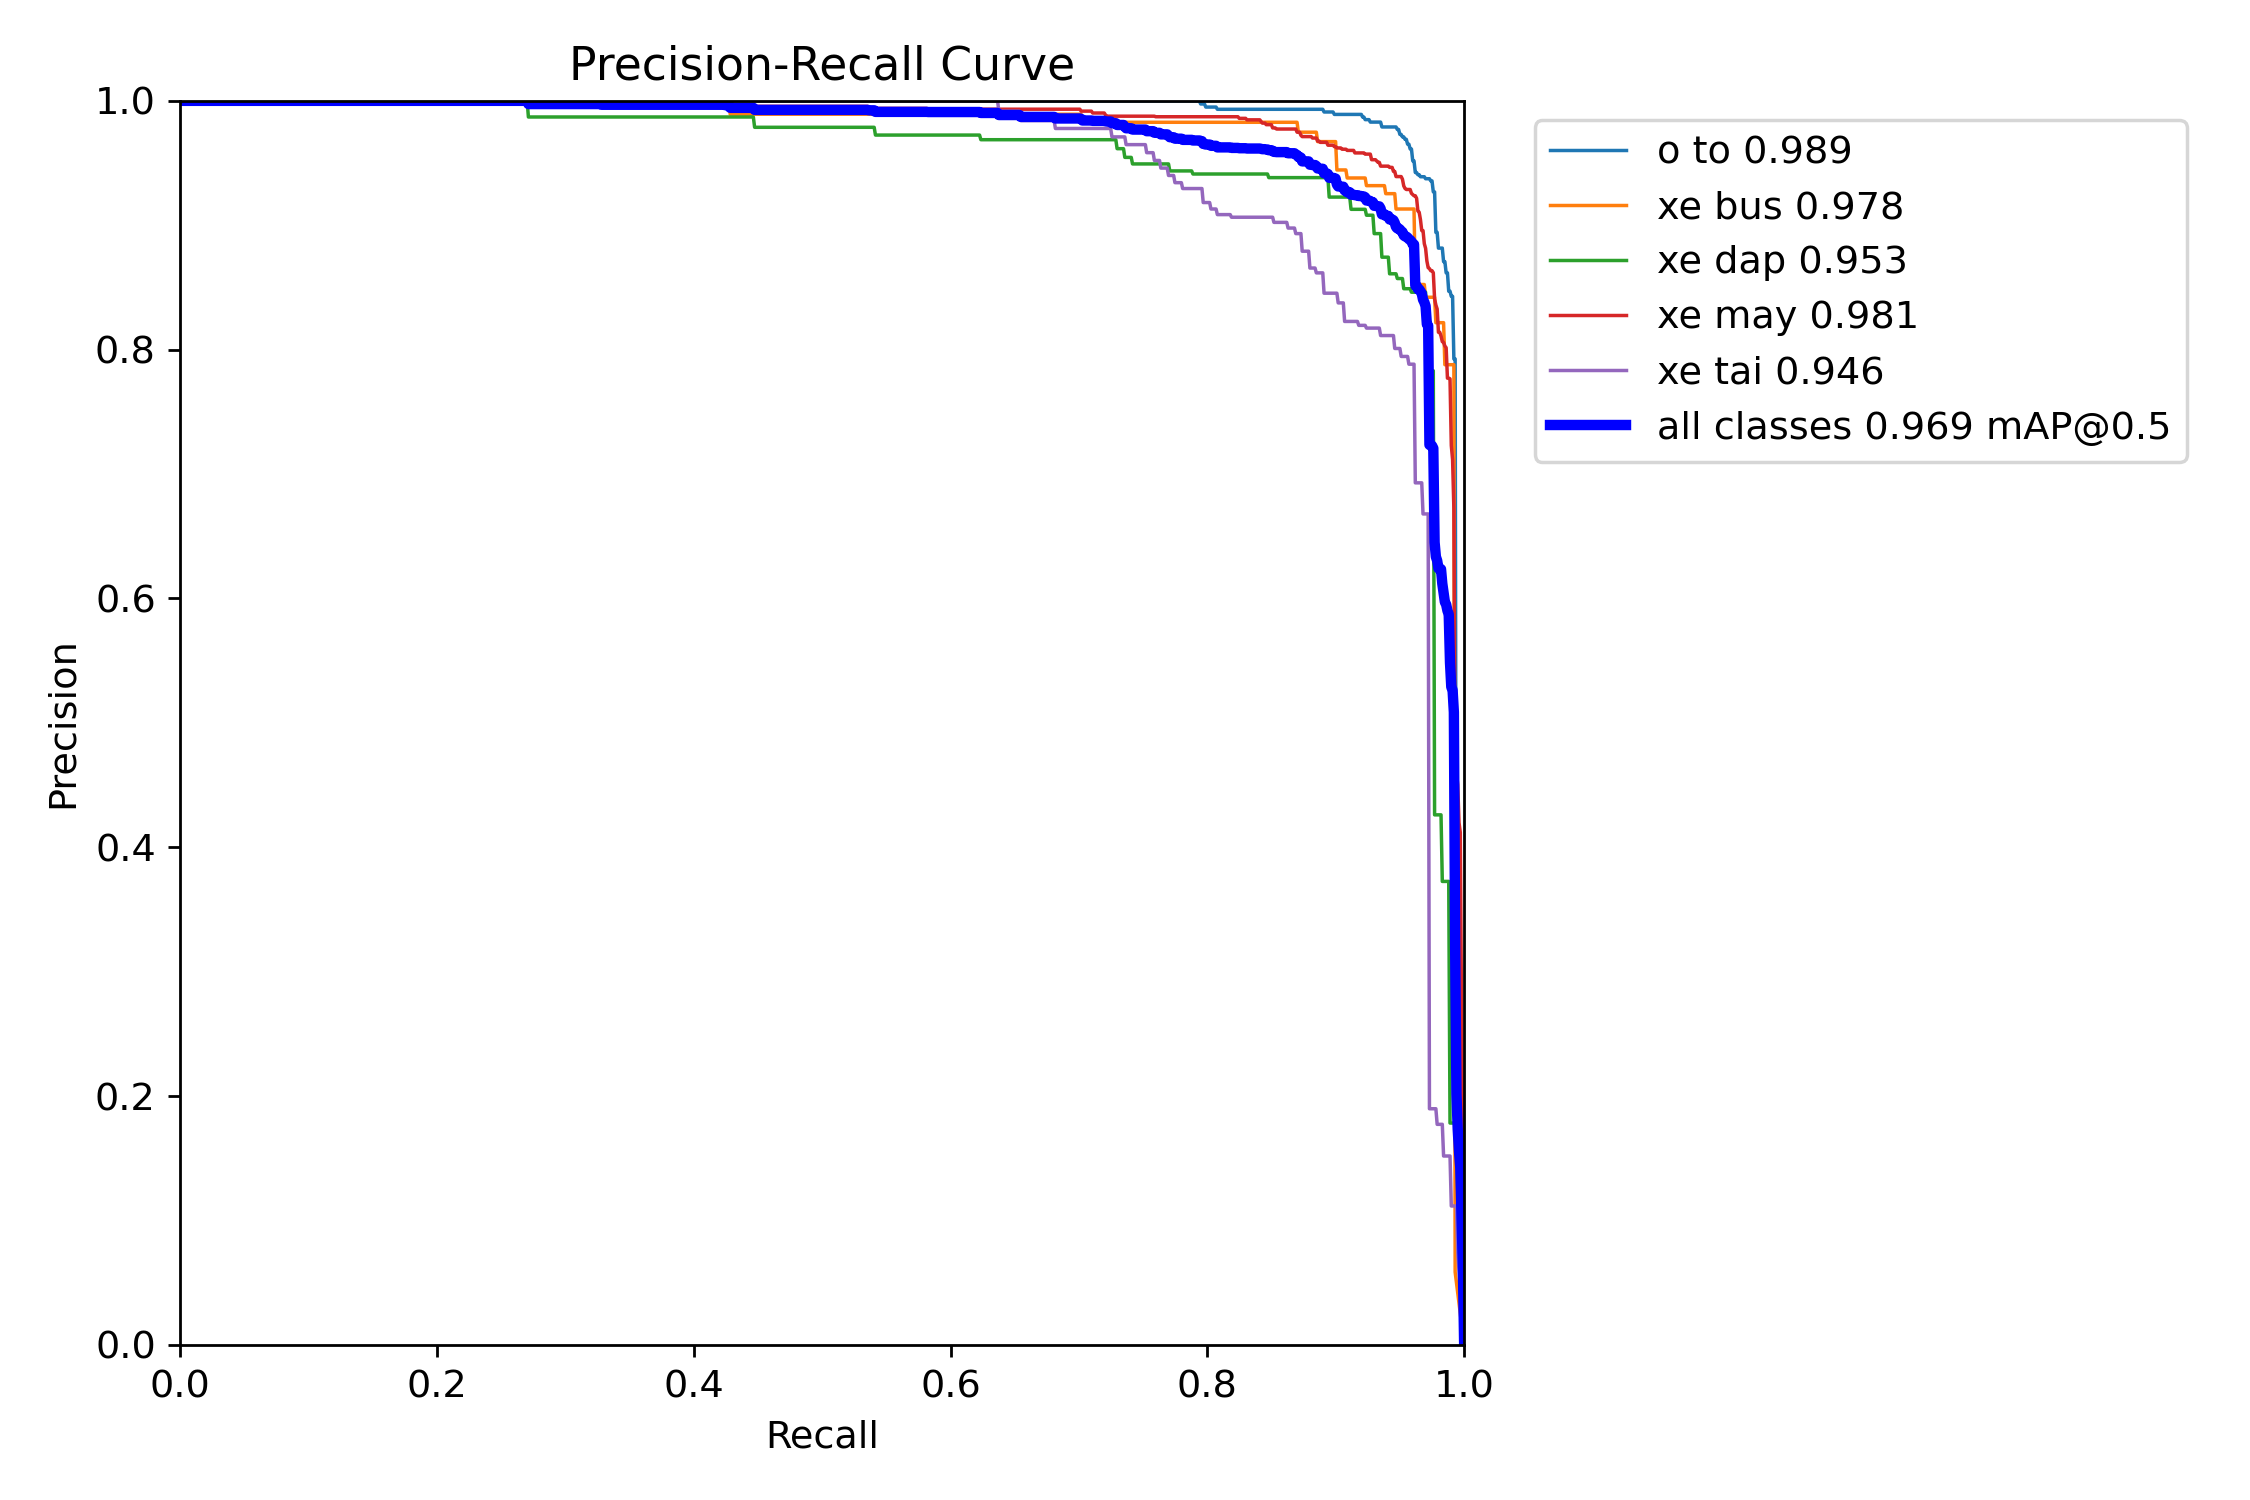

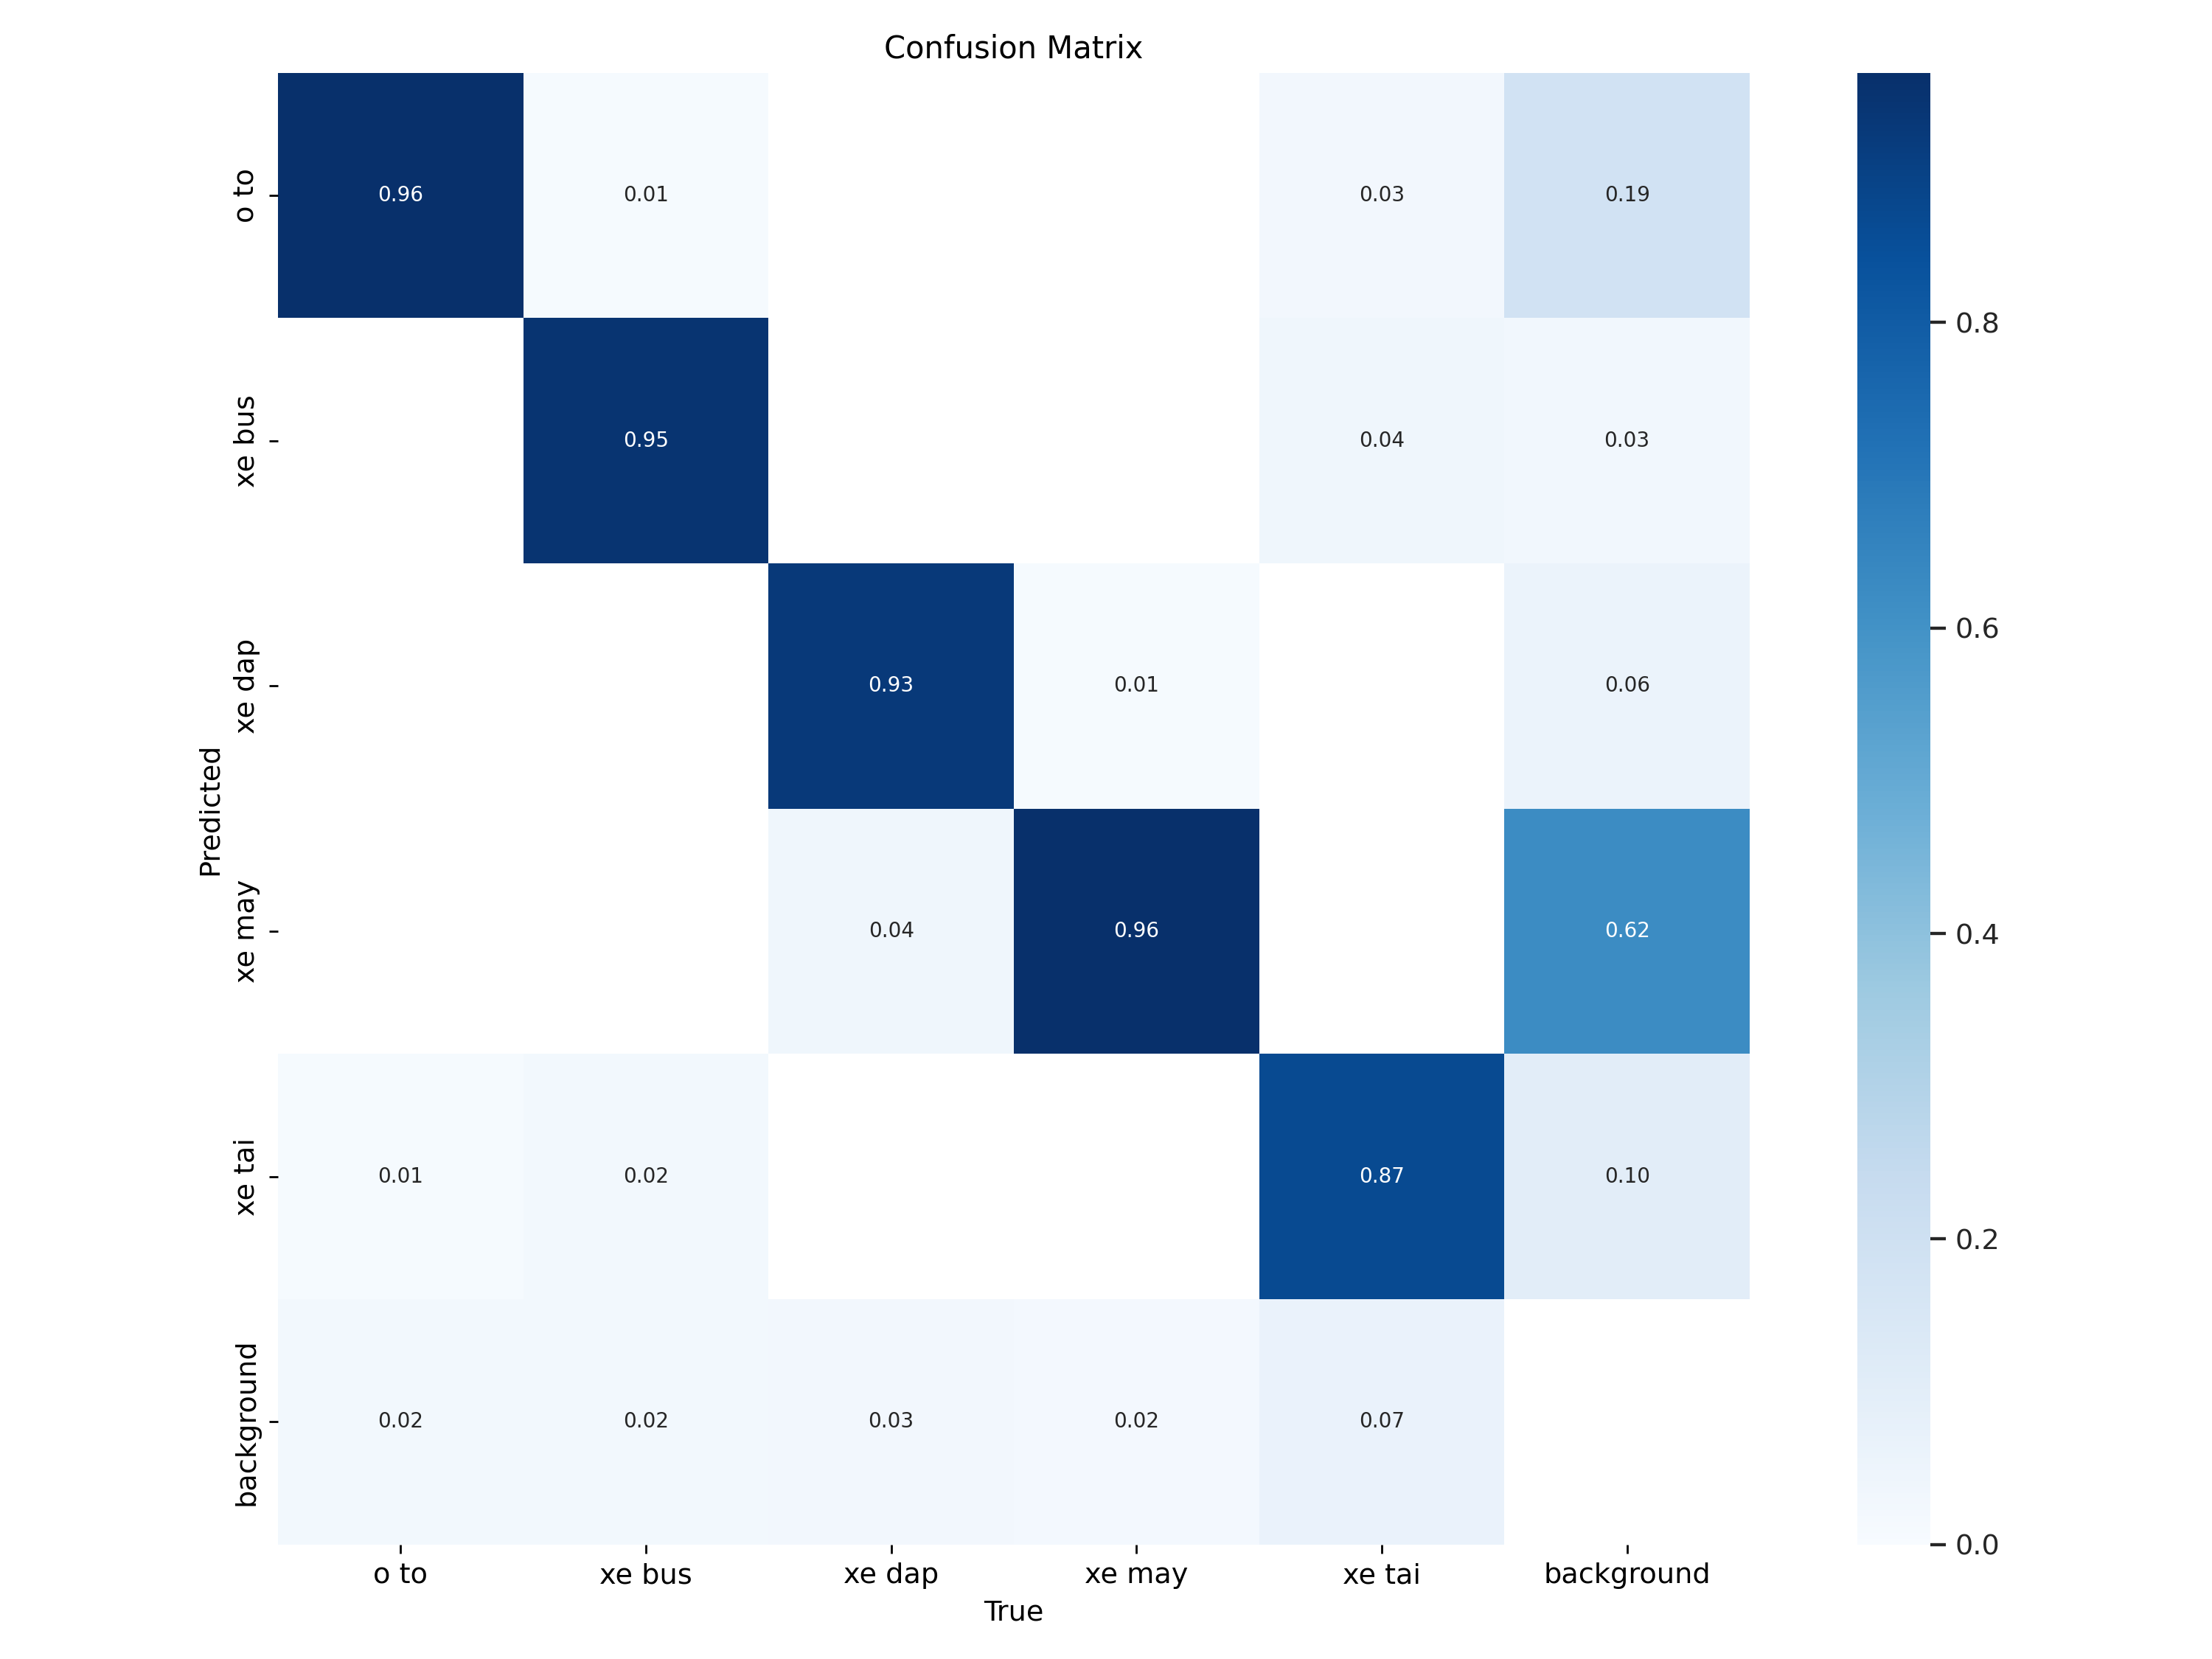

In [12]:
from IPython.display import Image, display

display(Image('/content/yolov5/runs/train/exp/PR_curve.png', width=500))
display(Image('/content/yolov5/runs/train/exp/confusion_matrix.png', width=500))

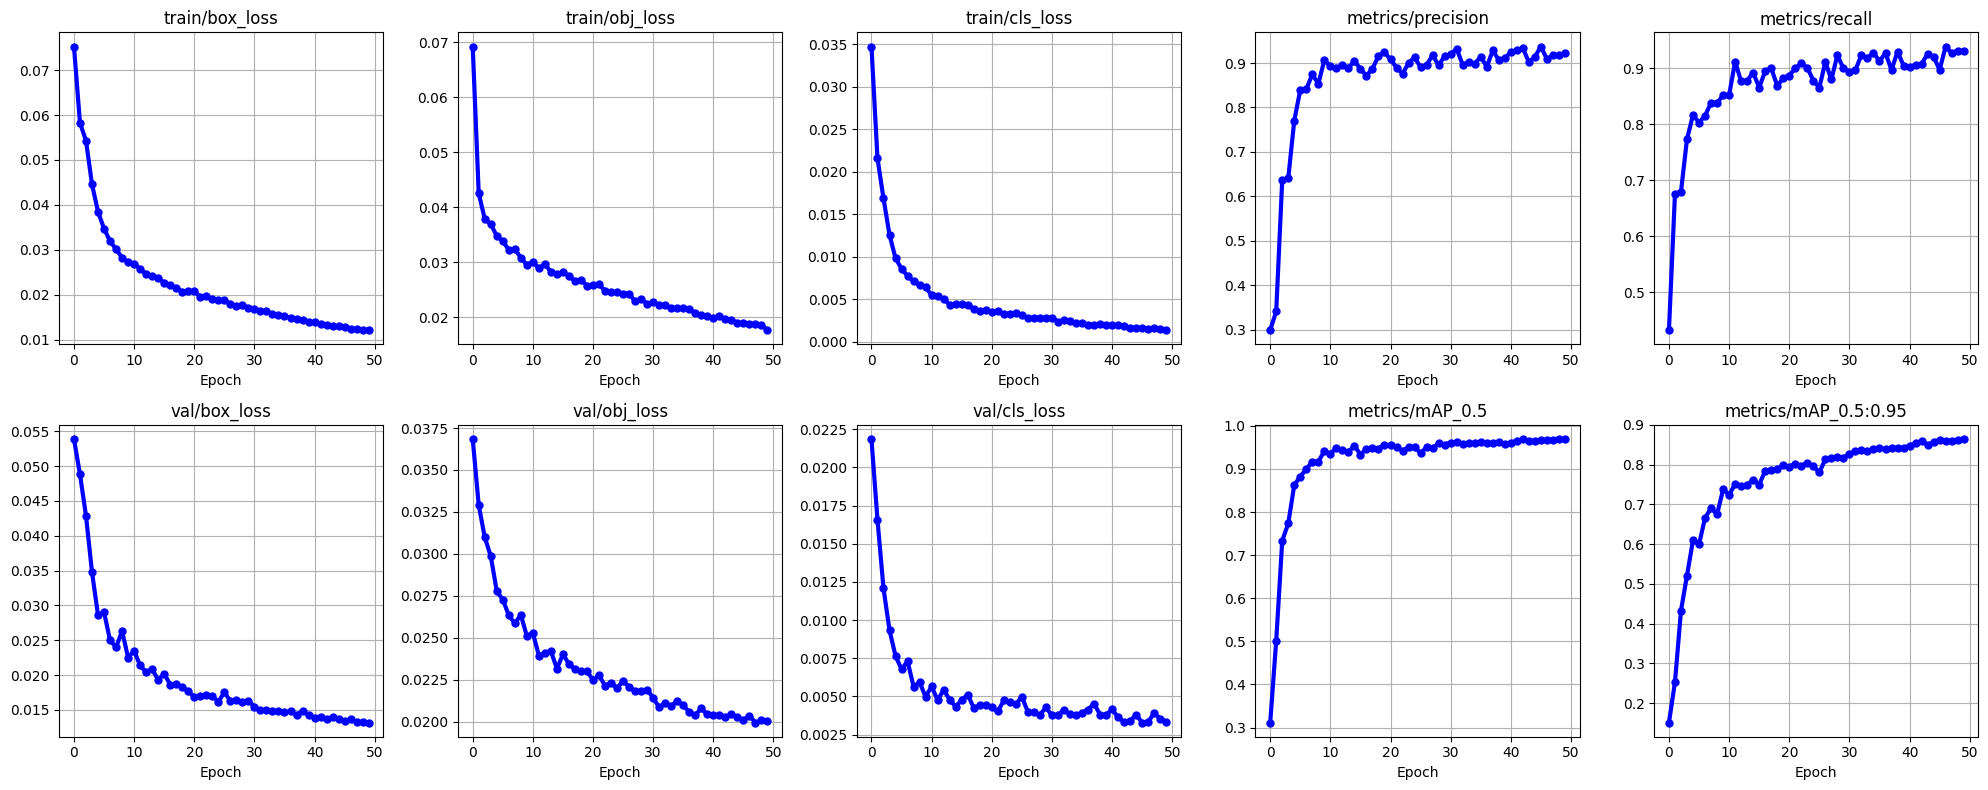

In [13]:
!pip install matplotlib pandas

# 1. Import thư viện
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Đọc file CSV (thay đường dẫn nếu bạn đã đổi tên hoặc vị trí)
csv_path = '/content/yolov5/runs/train/exp/results.csv'  # hoặc đường dẫn tới file bạn upload
df = pd.read_csv(csv_path)

# 3. Làm sạch tên cột (xóa khoảng trắng đầu/cuối)
df.columns = df.columns.str.strip()

# 4. Danh sách metric cần vẽ
metrics = [
    'train/box_loss', 'train/obj_loss', 'train/cls_loss',
    'metrics/precision', 'metrics/recall',
    'val/box_loss', 'val/obj_loss', 'val/cls_loss',
    'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95'
]

# 5. Vẽ biểu đồ 2 hàng x 5 cột
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, metric in enumerate(metrics):
    row, col = divmod(i, 5)
    axs[row][col].plot(
        df[metric],
        color='blue',
        linewidth=3,
        marker='o',
        markersize=5
    )
    axs[row][col].set_title(metric, fontsize=12)
    axs[row][col].set_xlabel('Epoch')
    axs[row][col].grid(True)

plt.tight_layout()
plt.show()

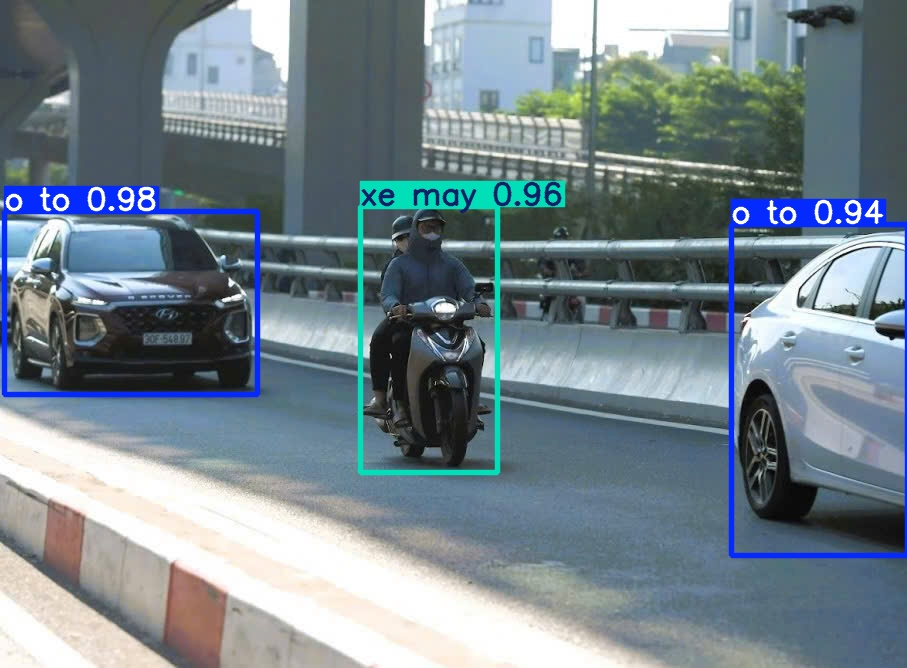

In [53]:
import glob
from IPython.display import Image, display

# Lấy danh sách ảnh kết quả
result_images = glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')

# Hiển thị 3 ảnh đầu tiên với kích thước 640x640
for img_path in result_images[:1]:
    display(Image(filename=img_path, height=640))



[🔍] Kiểm tra: anh 2
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: o to

[🔍] Kiểm tra: anh 2
→ Object 0: o to     ✔️ Hợp lệ
→ Object 1: xe may   ❌ VI PHẠM
→ Object 2: o to     ✔️ Hợp lệ
✅ Tổng cộng 1 VI PHẠM trong ảnh
Ảnh anh 2.jpg ✅ VI PHẠM


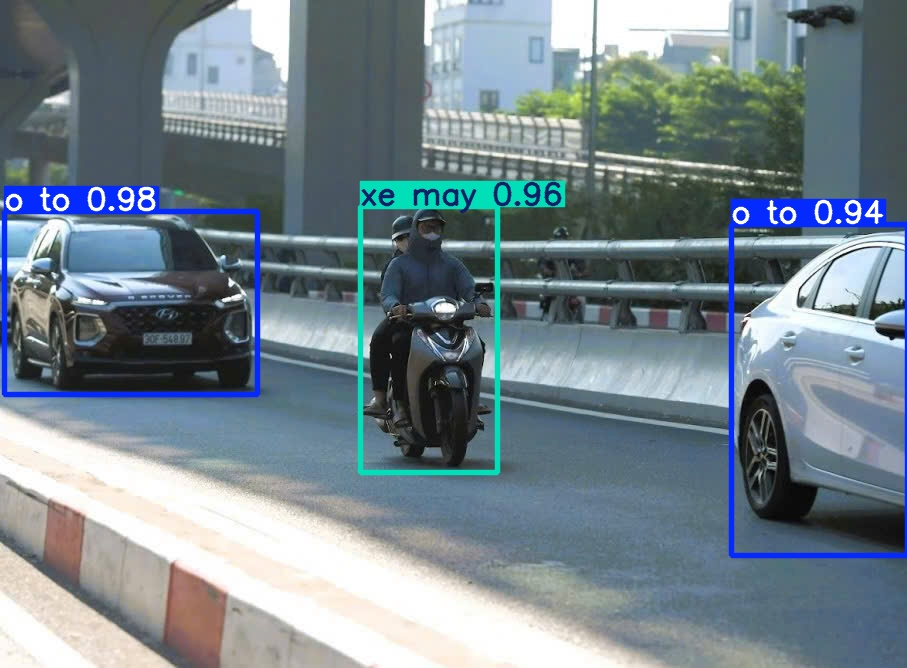


[🔍] Kiểm tra: anh 5
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: xe bus
 → Phát hiện object: xe tai
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: xe may

[🔍] Kiểm tra: anh 5
→ Object 0: o to     ✔️ Hợp lệ
→ Object 1: xe may   ❌ VI PHẠM
→ Object 2: xe bus   ❌ VI PHẠM
→ Object 3: xe tai   ✔️ Hợp lệ
→ Object 4: xe may   ❌ VI PHẠM
→ Object 5: o to     ✔️ Hợp lệ
→ Object 6: xe may   ❌ VI PHẠM
→ Object 7: xe may   ❌ VI PHẠM
→ Object 8: o to     ✔️ Hợp lệ
→ Object 9: o to     ✔️ Hợp lệ
→ Object 10: o to     ✔️ Hợp lệ
→ Object 11: xe may   ❌ VI PHẠM
✅ Tổng cộng 6 VI PHẠM trong ảnh
Ảnh anh 5.jpg ✅ VI PHẠM


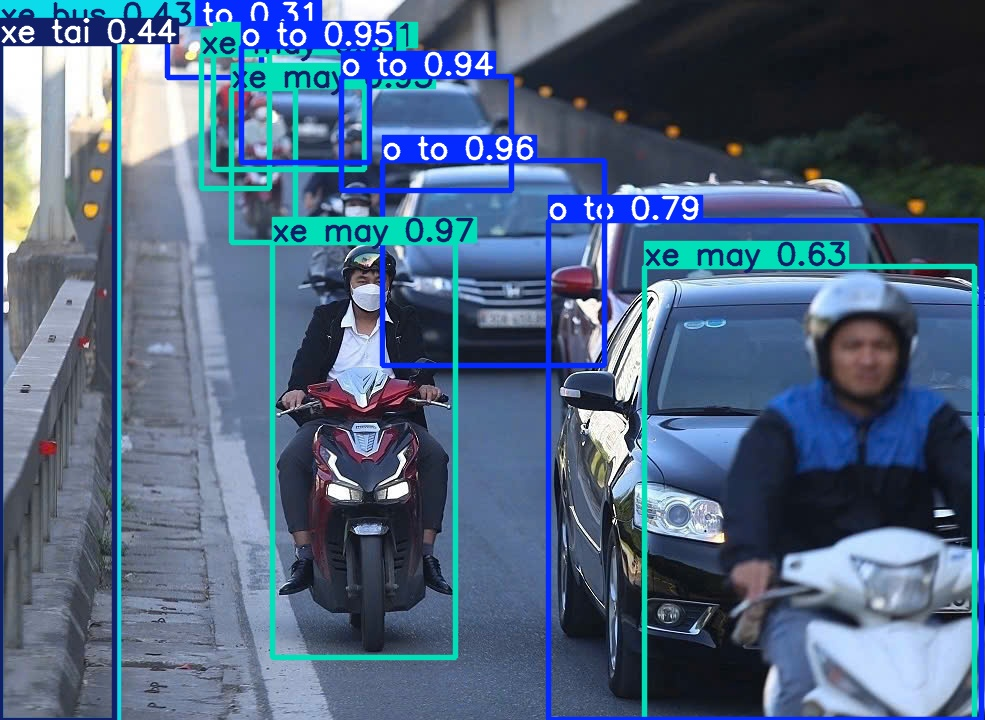


[🔍] Kiểm tra: anh 6
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: xe tai
 → Phát hiện object: xe tai
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: o to

[🔍] Kiểm tra: anh 6
→ Object 0: o to     ✔️ Hợp lệ
→ Object 1: o to     ✔️ Hợp lệ
→ Object 2: xe tai   ✔️ Hợp lệ
→ Object 3: xe tai   ✔️ Hợp lệ
→ Object 4: xe may   ❌ VI PHẠM
→ Object 5: o to     ✔️ Hợp lệ
→ Object 6: o to     ✔️ Hợp lệ
✅ Tổng cộng 1 VI PHẠM trong ảnh
Ảnh anh 6.jpg ✅ VI PHẠM


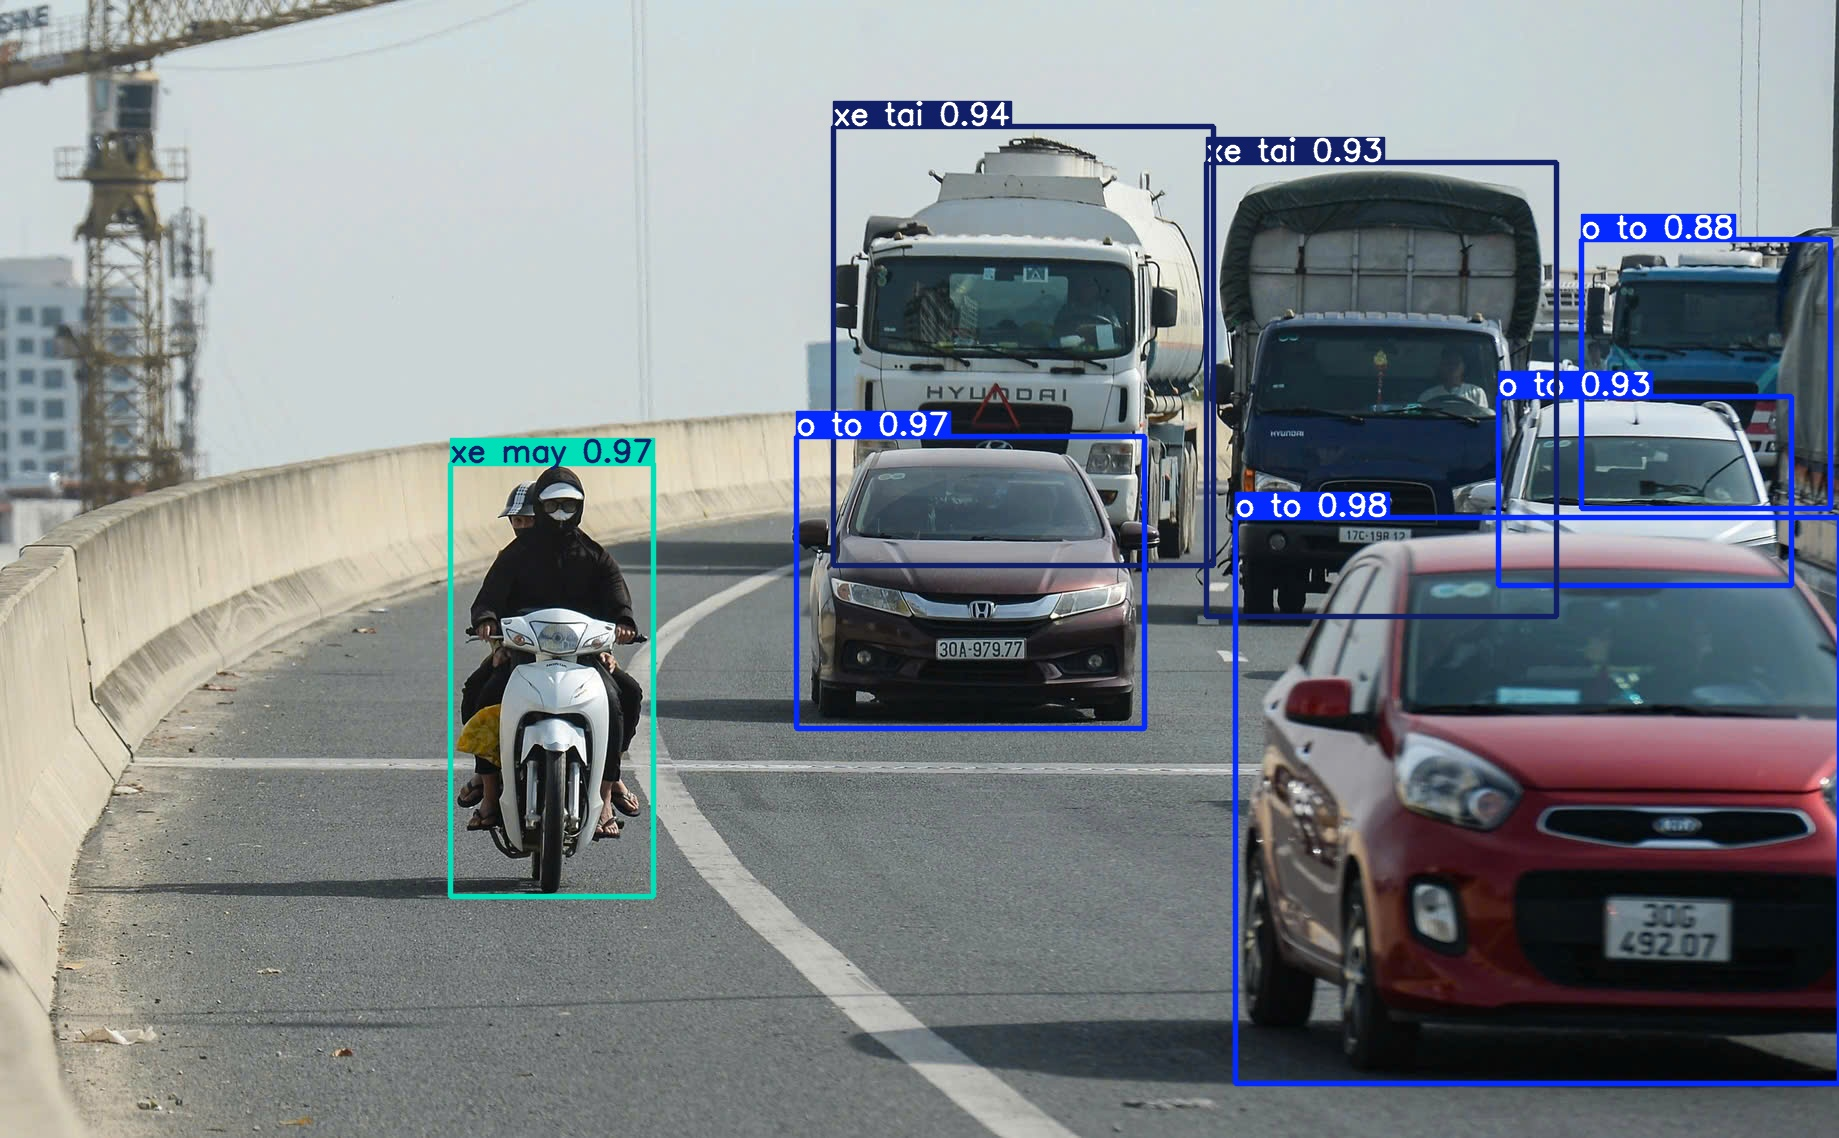


[🔍] Kiểm tra: ảnh 1
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: xe may
 → Phát hiện object: o to

[🔍] Kiểm tra: ảnh 1
→ Object 0: o to     ✔️ Hợp lệ
→ Object 1: xe may   ❌ VI PHẠM
→ Object 2: o to     ✔️ Hợp lệ
→ Object 3: xe may   ❌ VI PHẠM
→ Object 4: xe may   ❌ VI PHẠM
→ Object 5: o to     ✔️ Hợp lệ
✅ Tổng cộng 3 VI PHẠM trong ảnh
Ảnh ảnh 1.jpg ✅ VI PHẠM


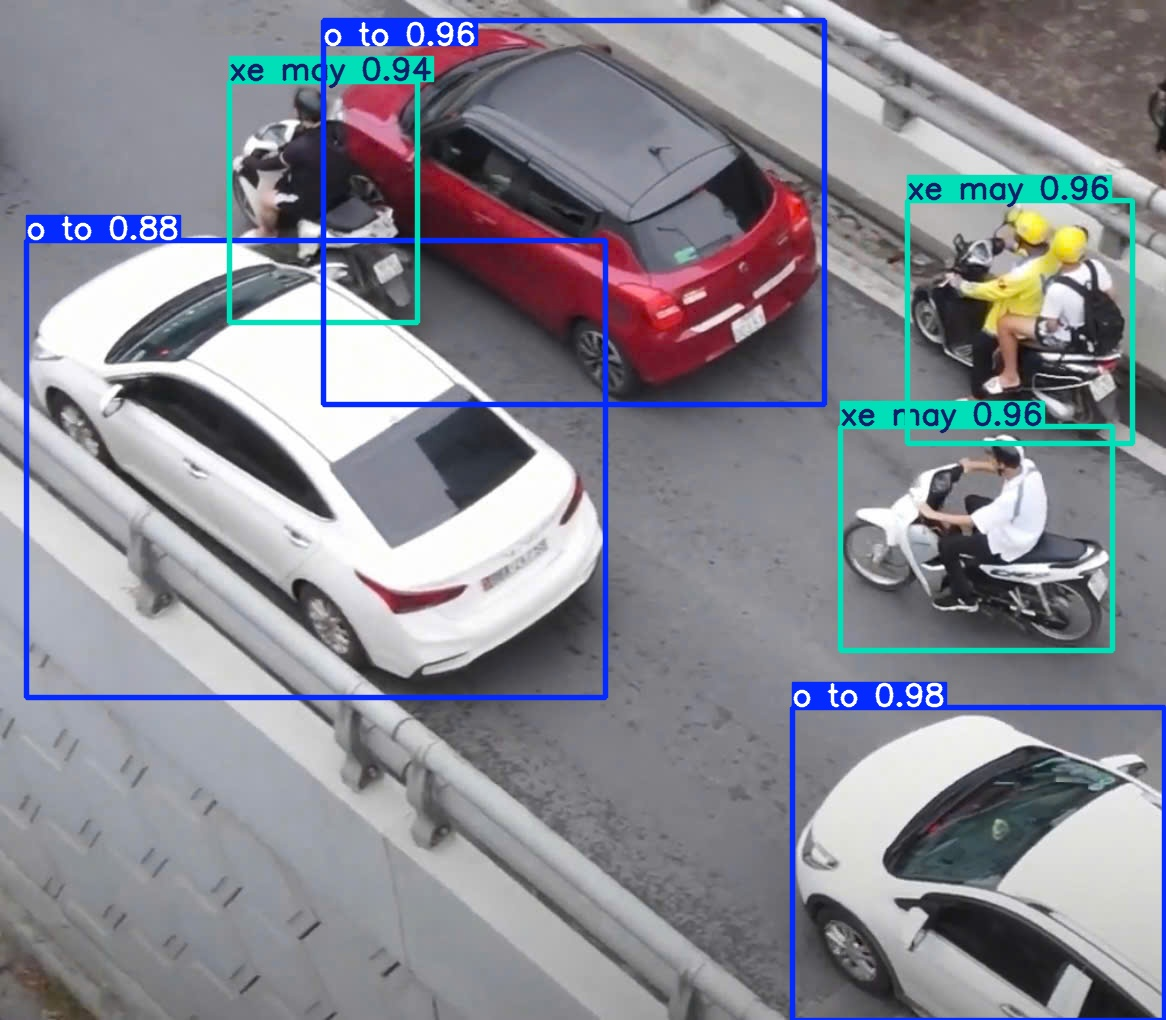


[🔍] Kiểm tra: anh 4
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: o to

[🔍] Kiểm tra: anh 4
→ Object 0: o to     ✔️ Hợp lệ
→ Object 1: o to     ✔️ Hợp lệ
→ Object 2: o to     ✔️ Hợp lệ
→ Object 3: xe may   ❌ VI PHẠM
→ Object 4: o to     ✔️ Hợp lệ
✅ Tổng cộng 1 VI PHẠM trong ảnh
Ảnh anh 4.jpg ✅ VI PHẠM


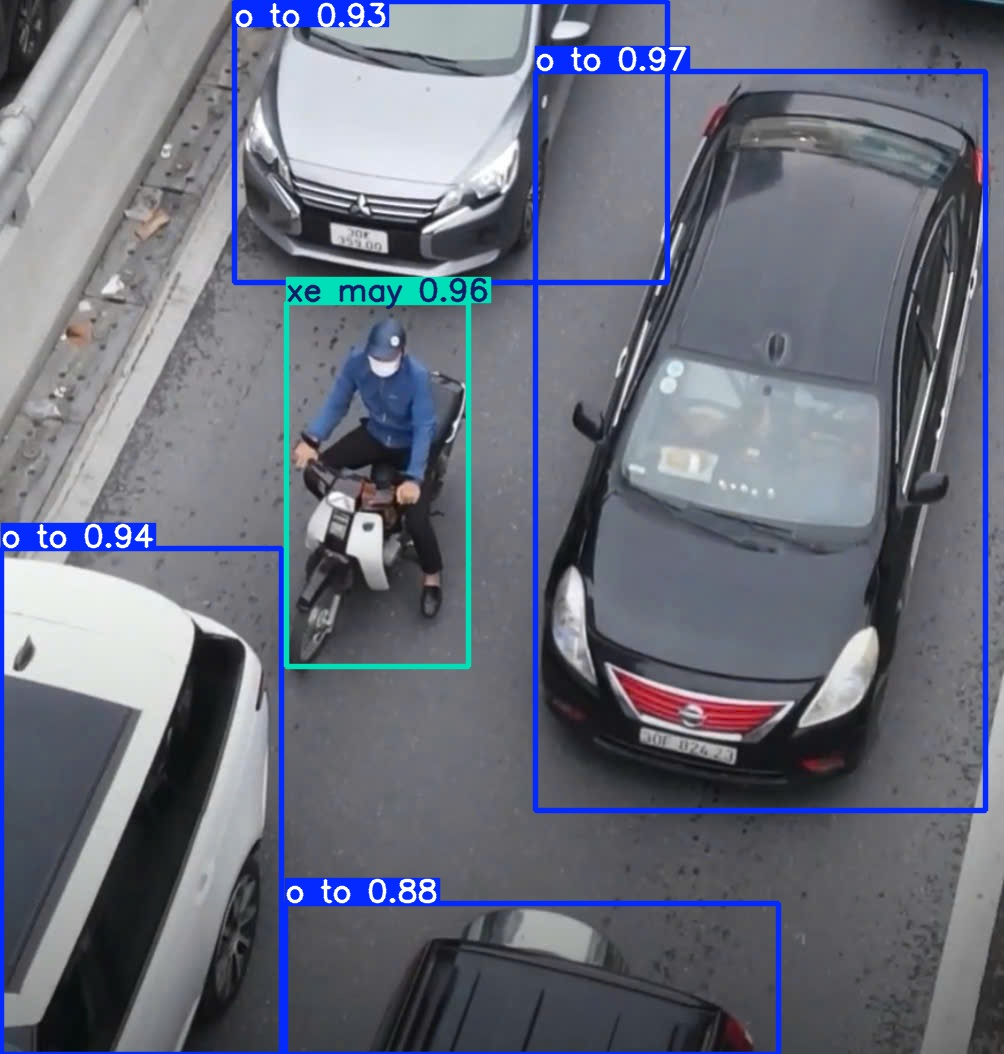


[🔍] Kiểm tra: anh 3
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: xe may
 → Phát hiện object: o to
 → Phát hiện object: o to
 → Phát hiện object: o to

[🔍] Kiểm tra: anh 3
→ Object 0: o to     ✔️ Hợp lệ
→ Object 1: o to     ✔️ Hợp lệ
→ Object 2: xe may   ❌ VI PHẠM
→ Object 3: o to     ✔️ Hợp lệ
→ Object 4: o to     ✔️ Hợp lệ
→ Object 5: o to     ✔️ Hợp lệ
✅ Tổng cộng 1 VI PHẠM trong ảnh
Ảnh anh 3.jpg ✅ VI PHẠM


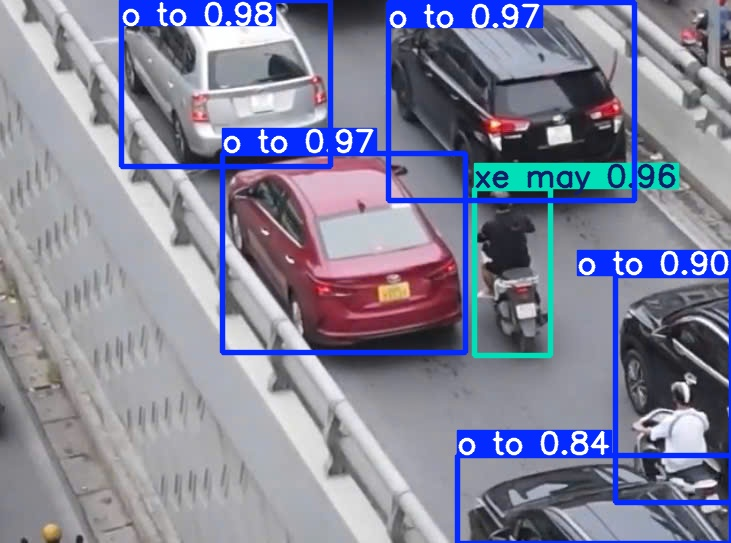

In [56]:
import glob
from IPython.display import Image, display
import os

# Định nghĩa danh sách các nhãn vi phạm
VIOLATION_CLASSES = ['xe may', 'xe dap', 'xe bus']

# Đường dẫn tới thư mục chứa kết quả phát hiện
detect_folder = '/content/yolov5/runs/detect/exp3'

# Hàm kiểm tra xem ảnh có chứa nhãn vi phạm không
def analyze_objects(label_path, class_names, violation_classes):
    if not os.path.exists(label_path):
        print(f"[❌] Không tìm thấy file nhãn: {label_path}")
        return False

    with open(label_path, 'r') as f:
        lines = f.readlines()

    violated = 0

    print(f"\n[🔍] Kiểm tra: {os.path.basename(label_path).replace('.txt', '')}")
    for idx, line in enumerate(lines):
        parts = line.strip().split()
        class_id = int(parts[0])
        class_name = class_names[class_id]

        if class_name in violation_classes:
            print(f"→ Object {idx}: {class_name:<8} ❌ VI PHẠM")
            violated += 1
        else:
            print(f"→ Object {idx}: {class_name:<8} ✔️ Hợp lệ")

    print(f"✅ Tổng cộng {violated} VI PHẠM trong ảnh")
    return violated > 0


# Danh sách tên class từ file YAML
class_names = ['o to', 'xe bus', 'xe dap', 'xe may', 'xe tai']

# Lấy danh sách ảnh kết quả
result_images = glob.glob(os.path.join(detect_folder, '*.jpg'))

# Hiển thị 3 ảnh đầu tiên với kích thước 640x640 và kiểm tra vi phạm
for img_path in result_images:

    file_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(detect_folder, 'labels', file_name + '.txt')

    if not os.path.exists(label_path):
        print(f"[❌] Không tìm thấy file nhãn: {label_path}")
        continue

    print(f"\n[🔍] Kiểm tra: {file_name}")
    with open(label_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        class_id = int(line.split()[0])
        class_name = class_names[class_id]
        print(f" → Phát hiện object: {class_name}")

    if analyze_objects(label_path, class_names, VIOLATION_CLASSES):
      print(f"Ảnh {os.path.basename(img_path)} ✅ VI PHẠM")
    else:
      print(f"Ảnh {os.path.basename(img_path)} ❎ KHÔNG vi phạm")

# Hiển thị ảnh___
    display(Image(filename=img_path, width=640, height=640))
